In [1]:
import numpy as np
import torch
torch.set_default_dtype(torch.float64)

import os
import sys

import matplotlib.pyplot as plt
import matplotlib
import itertools

from utils import load_data
import hardnet_aff
import hardnet_cvx
import baseline_dc3
import baseline_nn
from test_nets import load_net_hardnetaff, load_net_dc3, load_net_nn

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

matplotlib.rcParams['text.usetex'] = True
plt.style.use('seaborn-whitegrid')

def draw_functions(data, func_list, label_list, color_list, linestyle_list, show_data=False):
    """
    Plot the functions.
    """

    fig = plt.figure(figsize=(6, 4))
    
    X = data.X_eval
    x_np = X[:,0].numpy()
    border_lower = data.get_lower_bound(X)[:,0].numpy()
    border_upper = data.get_upper_bound(X)[:,0].numpy()
    plt.plot(x_np, data.Y_eval[:,0].numpy(), c='k', label='Ground Truth', markersize=1, alpha=0.8)
    if show_data:
        plt.scatter(data.trainX, data.trainY, s=20, marker='o', facecolor='none', edgecolors='k')#, label='Train Data')
    # plt.plot(x_np, border, ':', color='r')

    # plt.axis('equal')
    plt.xlim([-2,2])
    plt.ylim([-4,3])
    ylim = plt.gca().get_ylim()
    plt.fill_between(x_np, ylim[0], border_lower, color='r', alpha=0.1, edgecolor='none', label='Violated Area')
    plt.fill_between(x_np, border_upper, ylim[1], color='r', alpha=0.1, edgecolor='none')

    for func, label, c, ls in zip(func_list, label_list, color_list, linestyle_list):
        func.eval()
        Y = func(X, isTest=True)
        mse = torch.mean(data.get_eval_metric(func, X, Y, data.Y_eval))
        out_np = Y[:,0].detach().numpy()
        plt.plot(x_np, out_np, ls, color=c, label=label+' (%.2f)'%mse, markersize=1, alpha=0.8)
    
    # plt.title('Simulation Result')
    plt.xlabel(r'Input $x$')
    plt.ylabel(r'Output $y$')
    plt.grid(True)
    

    # legend
    ax = plt.gca()
    handles, _labels = ax.get_legend_handles_labels()
    flip = lambda items: itertools.chain(*[items[i::2] for i in range(2)])
    ax.legend(flip(handles), flip(_labels), ncol=2, frameon=True, loc='lower left')

    plt.show()

    return fig

colors = [(31, 119, 180), (255, 127, 14),
            (44, 160, 44), (214, 39, 40), 
            (148, 103, 189), (140, 86, 75),
            (227, 119, 194), (127, 127, 127),
            (188, 189, 34), (23, 190, 207)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(colors)):
    r, g, b = colors[i]
    colors[i] = (r / 255., g / 255., b / 255.)

folder_save = 'results/figures'

/tmp/ipykernel_3297700/3305824721.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


hardnetAff: {'probType': 'pwcbox', 'suffix': '', 'seed': 123, 'nEx': 10, 'epochs': 1000, 'batchSize': 500, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'evalFreq': 1, 'softWeight': 10, 'softEpochs': 100}
baselineNN: {'probType': 'pwcbox', 'suffix': '', 'seed': 123, 'nEx': 10, 'epochs': 1000, 'batchSize': 500, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'evalFreq': 1, 'softWeight': 0.0, 'testProj': 'none'}
baselineNN: {'probType': 'pwcbox', 'suffix': '', 'seed': 123, 'nEx': 10, 'epochs': 1000, 'batchSize': 500, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'evalFreq': 1, 'softWeight': 10, 'testProj': 'none'}
baselineDC3: {'probType': 'pwcbox', 'suffix': '', 'seed': 123, 'nEx': 10, 'epochs': 1000, 'batchSize': 500, 'lr': 0.0001, 'hiddenSize': 200, 'saveAllStats': True, 'resultsSaveFreq': 100, 'evalFreq': 1, 'softWeight': 10, 'useCompl': False, 'useTrainCorr': True, 'useTestCorr': False, 

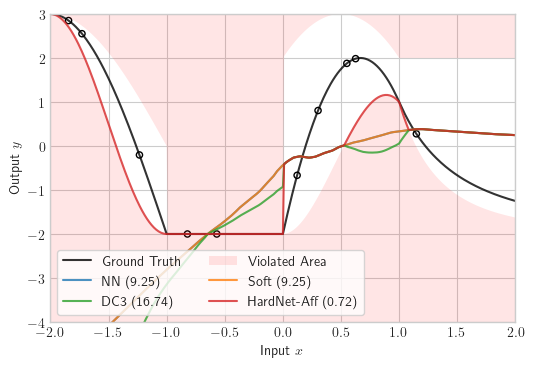

In [3]:
func_list = []
label_list = []

prob_type = 'pwcbox'
net_str = 'seed1/net_epoch0.dict' # ex) net_epoch0.dict, net.dict
exp_dir = 'results/PWCBoxProblem-10/'

sys.argv = ['hardnet_aff.py', '--probType', prob_type]
args = hardnet_aff.get_args('hardnetAff')
data = load_data(args, DEVICE)


# NN
sys.argv = ['baseline_nn.py', '--probType', prob_type, '--softWeight', '0.0']
args = baseline_nn.get_args('baselineNN')
path = exp_dir + 'baselineNN_noSoft/' + net_str
func_list.append(load_net_nn(data, args, path))
label_list.append('NN')

# Soft
sys.argv = ['baseline_nn.py', '--probType', prob_type]
args = baseline_nn.get_args('baselineNN')
path = exp_dir + 'baselineNN/' + net_str
func_list.append(load_net_nn(data, args, path))
label_list.append('Soft')

# DC3
sys.argv = ['baseline_dc3.py', '--probType', prob_type] # , '--corrLr', '1e-7'
args = baseline_dc3.get_args('baselineDC3')
path = exp_dir + 'baselineDC3/' + net_str
func_list.append(load_net_dc3(data, args, path))
label_list.append('DC3')

# HardNet-Aff
sys.argv = ['hardnet_aff.py', '--probType', prob_type]
args = hardnet_aff.get_args('hardnetAff')
path = exp_dir + 'hardnetAff/' + net_str
func_list.append(load_net_hardnetaff(data, args, path))
label_list.append('HardNet-Aff')


linestyle_list = ['-' if 'hardnet' in label else '-' for label in label_list]

fig = draw_functions(data, func_list, label_list, colors, linestyle_list, show_data=True)
# fig.savefig(folder_save+f'/{prob_type}_epoch1000.pdf',dpi=300, bbox_inches='tight')

# fig = draw_functions(data, [], [], colors, linestyle_list, show_data=True)
# fig.savefig(folder_save+f'/{prob_type}_setting.pdf',dpi=300, bbox_inches='tight')

In [4]:
import numpy as np
import os
from utils import get_results, get_table_from_dict, get_latex_from_table

exp_dir = os.path.join('results', 'PWCBoxProblem-10')
exp_status_dict, stats_dict = get_results(exp_dir, total_epoch=1000)

metrics = ['test_eval', 'train_loss', 'test_err1_max', 'test_err1_mean', 'test_err1_nviol', 'test_time', 'train_time']
metrics_renaming = ['MSE', 'Train loss', 'Max viol.', 'Mean viol.', 'Num viol.', 'Test Time (ms)', 'Train Time (s)']
baselines = ['baselineNN_noSoft', 'baselineNN', 'baselineDC3']
ours = ['hardnetAff']
methods_renaming_dict = dict((
        ('baselineDC3', 'DC3'),
        ('baselineNN_noSoft', 'NN'),
        ('baselineNN', 'Soft'),
        ('hardnetAff', 'HardNet-Aff')
    ))

df, missing_methods = get_table_from_dict(stats_dict, metrics, baselines + ours, test_time_unit='ms', train_time_unit='s')
df.index = [methods_renaming_dict[x] if x in methods_renaming_dict else x for x in df.index]
df.columns = metrics_renaming

df

Reading baselineNN...
  Reading seed4...
  Reading seed1...
  Reading seed3...
  Reading seed2...
  Reading seed5...
Reading hardnetAff...
  Reading seed4...
  Reading seed1...
  Reading seed3...
  Reading seed2...
  Reading seed5...
Reading baselineNN_noSoft...
  Reading seed4...
  Reading seed1...
  Reading seed3...
  Reading seed2...
  Reading seed5...
Reading baselineDC3...
  Reading seed4...
  Reading seed1...
  Reading seed3...
  Reading seed2...
  Reading seed5...


,MSE,Train loss,Max viol.,Mean viol.,Num viol.,Test Time (ms),Train Time (s)
NN,0.14 (0.04),0.01 (0.00),0.92 (0.15),0.12 (0.02),166.20 (5.60),0.14 (0.00),2.52 (0.09)
Soft,0.15 (0.05),0.06 (0.02),0.99 (0.18),0.11 (0.02),165.60 (8.62),0.16 (0.03),2.56 (0.07)
DC3,0.20 (0.10),0.04 (0.03),1.27 (0.43),0.12 (0.05),165.40 (8.55),6.84 (0.04),16.61 (0.16)
HardNet-Aff,0.15 (0.01),0.02 (0.00),0.00 (0.00),0.00 (0.00),0.00 (0.00),0.93 (0.01),5.29 (0.15)
